## prepare

In [ ]:
import pandas as pd
df = pd.read_csv('dealed_11_12_15_2021_0401_2021_0425.csv')
print(f'dealed_11_12_15_2021_0401_2021_0425.csv: {df.shape}')
df.head()

dealed_11_12_15_2021_0401_2021_0425.csv: (3157497, 13)


,Unnamed: 0,machine,timestamp,avgvalue,lastvalue,year,month,day,weekday,weekofyear,hour,minute,timing
0,0,CHS_TT11,2021-04-01 00:00:00,6.200000,6.200000,2021,4,1,Thursday,13,0,0,Night
1,1,CHR_TT12,2021-04-01 00:00:00,12.012501,12.012501,2021,4,1,Thursday,13,0,0,Night
2,2,CHR_TT15,2021-04-01 00:00:00,9.325001,9.312501,2021,4,1,Thursday,13,0,0,Night
3,3,CHS_TT11,2021-04-01 00:00:02,6.200000,6.200000,2021,4,1,Thursday,13,0,0,Night
4,4,CHR_TT12,2021-04-01 00:00:02,12.000001,12.000001,2021,4,1,Thursday,13,0,0,Night


In [ ]:
df.tail()

,Unnamed: 0,machine,timestamp,avgvalue,lastvalue,year,month,day,weekday,weekofyear,hour,minute,timing
3157492,3157492,CHR_TT12,2021-04-25 23:59:56,12.018751,12.025001,2021,4,25,Sunday,16,23,59,Night
3157493,3157493,CHS_TT11,2021-04-25 23:59:56,6.818750,6.825000,2021,4,25,Sunday,16,23,59,Night
3157494,3157494,CHS_TT11,2021-04-25 23:59:58,6.825000,6.825000,2021,4,25,Sunday,16,23,59,Night
3157495,3157495,CHR_TT12,2021-04-25 23:59:58,12.025001,12.025001,2021,4,25,Sunday,16,23,59,Night
3157496,3157496,CHR_TT15,2021-04-25 23:59:58,9.062500,9.050000,2021,4,25,Sunday,16,23,59,Night


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

## Plot the data

In [ ]:
df.head(3)

,Unnamed: 0,machine,timestamp,avgvalue,lastvalue,year,month,day,weekday,weekofyear,hour,minute,timing
0,0,CHS_TT11,2021-04-01,6.200000,6.200000,2021,4,1,Thursday,13,0,0,Night
1,1,CHR_TT12,2021-04-01,12.012501,12.012501,2021,4,1,Thursday,13,0,0,Night
2,2,CHR_TT15,2021-04-01,9.325001,9.312501,2021,4,1,Thursday,13,0,0,Night


In [ ]:
TT11 = df[df["machine"] == "CHS_TT11"]
TT11 = TT11.reset_index()
TT11.head()

,index,Unnamed: 0,machine,timestamp,avgvalue,lastvalue,year,month,day,weekday,weekofyear,hour,minute,timing
0,0,0,CHS_TT11,2021-04-01 00:00:00,6.2,6.2,2021,4,1,Thursday,13,0,0,Night
1,3,3,CHS_TT11,2021-04-01 00:00:02,6.2,6.2,2021,4,1,Thursday,13,0,0,Night
2,6,6,CHS_TT11,2021-04-01 00:00:04,6.2,6.2,2021,4,1,Thursday,13,0,0,Night
3,9,9,CHS_TT11,2021-04-01 00:00:06,6.2,6.2,2021,4,1,Thursday,13,0,0,Night
4,12,12,CHS_TT11,2021-04-01 00:00:08,6.2,6.2,2021,4,1,Thursday,13,0,0,Night


In [ ]:
TT11.to_csv("machine_tt11.csv")

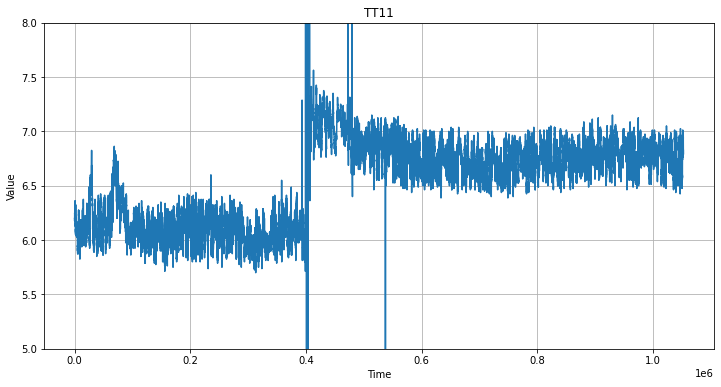

In [ ]:
df = pd.read_csv('dealed_11_12_15_2021_0401_2021_0425.csv')
time_step = []
series = []

with open("machine_tt11.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter = ",")
    # don't read first line
    next(reader)
    for row in reader:
     series.append(float(row[6]))
     time_step.append(int(row[0]))
TT11_series = np.array(series)
time = np.array(time_step)
plt.figure(figsize = (12, 6))
plt.ylim((5.0, 8.0))
plt.title("TT11")
plot_series(time, TT11_series)

### dataset 350000

In [ ]:
TT11_series_350000 = TT11_series[:350000]
time_350000 = time[:350000]
split_time = 348000
time_train = time_350000[:split_time]
x_train = TT11_series_350000[:split_time]
time_valid = time_350000[split_time:]
x_valid = TT11_series_350000[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
    
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(200, input_shape = [window_size], activation = "relu"),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss = "mse", optimizer = tf.keras.optimizers.SGD(lr = 1e-7, momentum = 0.9))
model.fit(dataset, epochs = 10, verbose = 2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
10874/10874 - 46s - loss: 0.9691
Epoch 2/10
10874/10874 - 46s - loss: 3.9589e-04
Epoch 3/10
10874/10874 - 45s - loss: 3.9267e-04
Epoch 4/10
10874/10874 - 45s - loss: 3.8892e-04
Epoch 5/10
10874/10874 - 45s - loss: 3.8462e-04
Epoch 6/10
10874/10874 - 45s - loss: 3.8105e-04
Epoch 7/10
10874/10874 - 45s - loss: 3.7854e-04
Epoch 8/10
10874/10874 - 45s - loss: 3.7666e-04
Epoch 9/10
10874/10874 - 45s - loss: 3.7469e-04
Epoch 10/10
10874/10874 - 45s - loss: 3.6866e-04


In [ ]:
len(TT11_series_350000) - window_size

349940

In [ ]:
split_time

348000

In [ ]:
time_valid

array([348000, 348001, 348002, ..., 349997, 349998, 349999])

In [ ]:
forecast = []
for ti in range(split_time - window_size, len(TT11_series_350000) - window_size):
    forecast.append(model.predict(TT11_series_350000[ti:ti + window_size][np.newaxis]))

In [ ]:
len(forecast)

2000

0.012689961


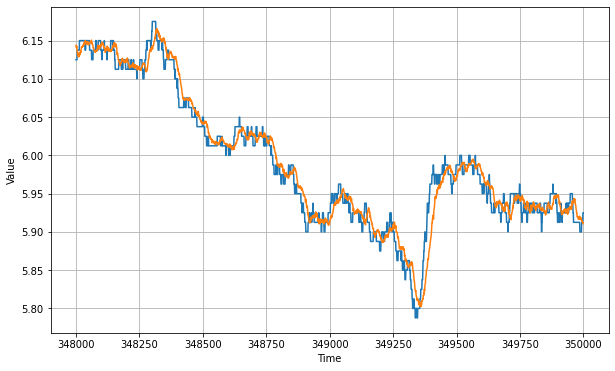

In [ ]:
# forecast = []
# for time in range(len(TT11_series_350000) - window_size):
#     forecast.append(model.predict(TT11_series_350000[time:time + window_size][np.newaxis]))
    
# forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

In [ ]:
x_valid[:10]

array([6.125 , 6.125 , 6.125 , 6.125 , 6.125 , 6.1375, 6.1375, 6.1375,
       6.1375, 6.1375])

In [ ]:
forecast[:10]

[array([[6.1436462]], dtype=float32),
 array([[6.1421227]], dtype=float32),
 array([[6.140769]], dtype=float32),
 array([[6.1428256]], dtype=float32),
 array([[6.1389217]], dtype=float32),
 array([[6.1373205]], dtype=float32),
 array([[6.1336527]], dtype=float32),
 array([[6.131386]], dtype=float32),
 array([[6.134033]], dtype=float32),
 array([[6.1290116]], dtype=float32)]

# Try Tensorflow LSTM

In [ ]:
TT11_series_350000 = TT11_series[:350000]
time_350000 = time[:350000]
split_time = 348000
time_train = time_350000[:split_time]
x_train = TT11_series_350000[:split_time]
time_valid = time_350000[split_time:]
x_valid = TT11_series_350000[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# need special input setting, because we using CNN layer first
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                        strides = 1, padding = "causal",
                        activation = "relu",
                        input_shape = [None, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [ ]:
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                        strides = 1, padding = "causal",
                        activation = "relu",
                        input_shape = [None, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1360/1360 [==============================] - 85s 39ms/step - loss: 0.4257 - mae: 0.5879
Epoch 2/10
1360/1360 [==============================] - 52s 38ms/step - loss: 0.0080 - mae: 0.0945
Epoch 3/10
1360/1360 [==============================] - 53s 39ms/step - loss: 0.0033 - mae: 0.0609
Epoch 4/10
1360/1360 [==============================] - 53s 39ms/step - loss: 0.0020 - mae: 0.0460
Epoch 5/10
1360/1360 [==============================] - 52s 38ms/step - loss: 0.0016 - mae: 0.0373
Epoch 6/10
1360/1360 [==============================] - 52s 38ms/step - loss: 0.0014 - mae: 0.0328
Epoch 7/10
1360/1360 [==============================] - 52s 38ms/step - loss: 0.0014 - mae: 0.0305
Epoch 8/10
1360/1360 [==============================] - 53s 39ms/step - loss: 0.0014 - mae: 0.0293
Epoch 9/10
1360/1360 [==============================] - 52s 38ms/step - loss: 0.0014 - mae: 0.0287
Epoch 10/10
1360/1360 [==============================] - 52s 38ms/step - loss: 0.0013 - mae: 0.0285


In [ ]:
rnn_forecast = model_forecast(model, TT11_series_350000[...,np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

0.0077311154


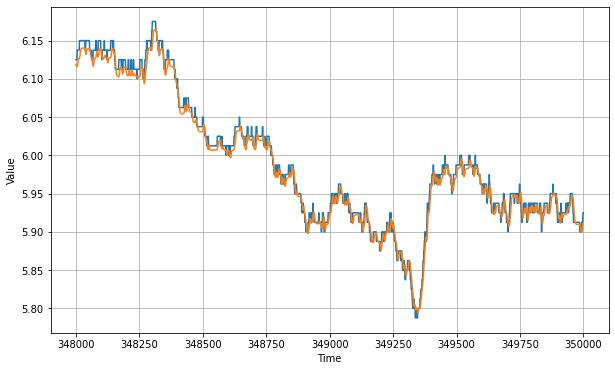

In [ ]:
# rnn_forecast = model_forecast(model, TT11_series_350000[...,np.newaxis], window_size)
# rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

In [ ]:
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                        strides = 1, padding = "causal",
                        activation = "relu",
                        input_shape = [None, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
1360/1360 [==============================] - 53s 37ms/step - loss: 0.6724 - mae: 0.9711
Epoch 2/100
1360/1360 [==============================] - 51s 37ms/step - loss: 0.2420 - mae: 0.5130
Epoch 3/100
1360/1360 [==============================] - 51s 37ms/step - loss: 0.1484 - mae: 0.4112
Epoch 4/100
1360/1360 [==============================] - 51s 37ms/step - loss: 0.0916 - mae: 0.3388
Epoch 5/100
1360/1360 [==============================] - 51s 37ms/step - loss: 0.0710 - mae: 0.3011
Epoch 6/100
1360/1360 [==============================] - 50s 37ms/step - loss: 0.0606 - mae: 0.2774
Epoch 7/100
1360/1360 [==============================] - 51s 37ms/step - loss: 0.0524 - mae: 0.2570
Epoch 8/100
1360/1360 [==============================] - 52s 38ms/step - loss: 0.0451 - mae: 0.2372
Epoch 9/100
1360/1360 [==============================] - 51s 37ms/step - loss: 0.0385 - mae: 0.2182
Epoch 10/100
1360/1360 [==============================] - 51s 37ms/step - loss: 0.0314 - mae: 0.1978

(0.0, 0.02)

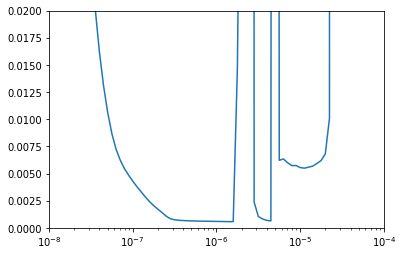

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.ylim([0, 0.1])
plt.axis([1e-8, 1e-4, 0, 60])
plt.ylim([0, 0.02])

pick learning rate 1e-6

In [ ]:
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                        strides = 1, padding = "causal",
                        activation = "relu",
                        input_shape = [None, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=30)

Epoch 1/30
1360/1360 [==============================] - 54s 38ms/step - loss: 0.2107 - mae: 0.3446
Epoch 2/30
1360/1360 [==============================] - 52s 38ms/step - loss: 0.0085 - mae: 0.0821
Epoch 3/30
1360/1360 [==============================] - 52s 38ms/step - loss: 0.0051 - mae: 0.0653
Epoch 4/30
1360/1360 [==============================] - 52s 38ms/step - loss: 0.0033 - mae: 0.0545
Epoch 5/30
1360/1360 [==============================] - 52s 38ms/step - loss: 0.0019 - mae: 0.0413
Epoch 6/30
1360/1360 [==============================] - 53s 39ms/step - loss: 0.0014 - mae: 0.0361
Epoch 7/30
1360/1360 [==============================] - 52s 38ms/step - loss: 0.0013 - mae: 0.0342
Epoch 8/30
1360/1360 [==============================] - 52s 38ms/step - loss: 0.0012 - mae: 0.0331
Epoch 9/30
1360/1360 [==============================] - 52s 38ms/step - loss: 0.0011 - mae: 0.0322
Epoch 10/30
1360/1360 [==============================] - 51s 38ms/step - loss: 0.0011 - mae: 0.0315
Epoch 11/

In [ ]:
rnn_forecast = model_forecast(model, TT11_series_350000[...,np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

0.017690342


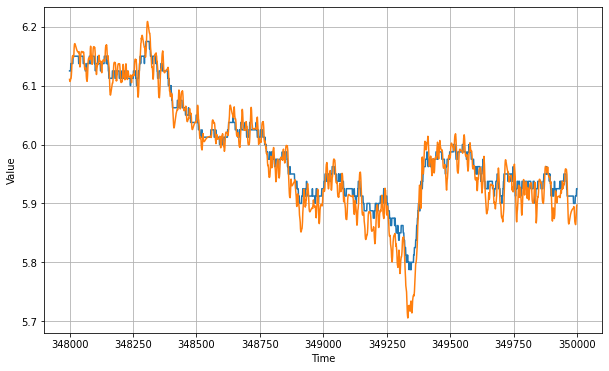

In [ ]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

## predict next 10 seconds (5 x 2seconds)

In [ ]:
TT11_series_350000 = TT11_series[:350000]
time_350000 = time[:350000]
split_time = 348000
time_train = time_350000[:split_time]
x_train = TT11_series_350000[:split_time]
time_valid = time_350000[split_time:]
x_valid = TT11_series_350000[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-5], w[5:]))
    return ds.batch(batch_size).prefetch(1)

# need special input setting, because we using CNN layer first
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                        strides = 1, padding = "causal",
                        activation = "relu",
                        input_shape = [None, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Lambda(lambda x: x * 400)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense_3 (Dense)              (None, None, 30)          1950      
_________________________________________________________________
dense_4 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_5 (Dense)              (None, None, 5)           55        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 5)          

In [ ]:
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                        strides = 1, padding = "causal",
                        activation = "relu",
                        input_shape = [None, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1360/1360 [==============================] - 85s 38ms/step - loss: 0.1821 - mae: 0.2736
Epoch 2/10
1360/1360 [==============================] - 50s 36ms/step - loss: 0.0048 - mae: 0.0697
Epoch 3/10
1360/1360 [==============================] - 49s 36ms/step - loss: 0.0045 - mae: 0.0670
Epoch 4/10
1360/1360 [==============================] - 49s 36ms/step - loss: 0.0043 - mae: 0.0647
Epoch 5/10
1360/1360 [==============================] - 50s 37ms/step - loss: 0.0043 - mae: 0.0643
Epoch 6/10
1360/1360 [==============================] - 50s 37ms/step - loss: 0.0042 - mae: 0.0640
Epoch 7/10
1360/1360 [==============================] - 50s 36ms/step - loss: 0.0042 - mae: 0.0637
Epoch 8/10
1360/1360 [==============================] - 50s 37ms/step - loss: 0.0041 - mae: 0.0634
Epoch 9/10
1360/1360 [==============================] - 49s 36ms/step - loss: 0.0041 - mae: 0.0634
Epoch 10/10
1360/1360 [==============================] - 49s 36ms/step - loss: 0.0042 - mae: 0.0638


In [ ]:
rnn_forecast = model_forecast(model, TT11_series_350000[...,np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

0.035804514


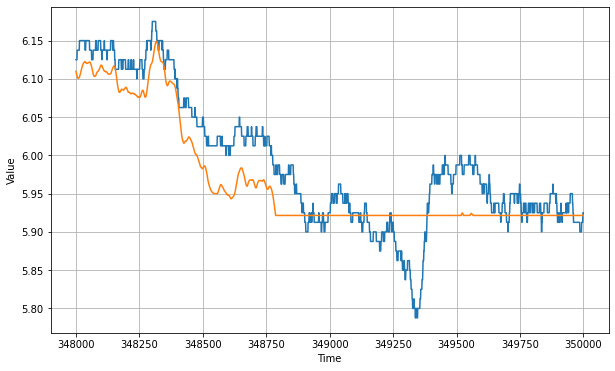

In [ ]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

### LSTM Train ALL

In [ ]:
split_time = 1049000
time_train = time[:split_time]
x_train = TT11_series[:split_time]
time_valid = time[split_time:]
x_valid = TT11_series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# need special input setting, because we using CNN layer first
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                        strides = 1, padding = "causal",
                        activation = "relu",
                        input_shape = [None, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
4098/4098 [==============================] - 152s 36ms/step - loss: 0.1538 - mae: 0.2546
Epoch 2/10
4098/4098 [==============================] - 149s 36ms/step - loss: 0.0152 - mae: 0.0814
Epoch 3/10
4098/4098 [==============================] - 149s 36ms/step - loss: 0.0112 - mae: 0.0672
Epoch 4/10
4098/4098 [==============================] - 148s 36ms/step - loss: 0.0114 - mae: 0.0615
Epoch 5/10
4098/4098 [==============================] - 147s 36ms/step - loss: 0.0164 - mae: 0.0654
Epoch 6/10
4098/4098 [==============================] - 148s 36ms/step - loss: 0.0060 - mae: 0.0486
Epoch 7/10
4098/4098 [==============================] - 150s 37ms/step - loss: 0.0050 - mae: 0.0434
Epoch 8/10
4098/4098 [==============================] - 147s 36ms/step - loss: 0.0039 - mae: 0.0388
Epoch 9/10
4098/4098 [==============================] - 147s 36ms/step - loss: 0.0031 - mae: 0.0356
Epoch 10/10
4098/4098 [==============================] - 148s 36ms/step - loss: 0.0027 - mae: 0.0332

In [ ]:
rnn_forecast = model_forecast(model, TT11_series[...,np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

0.0133381635


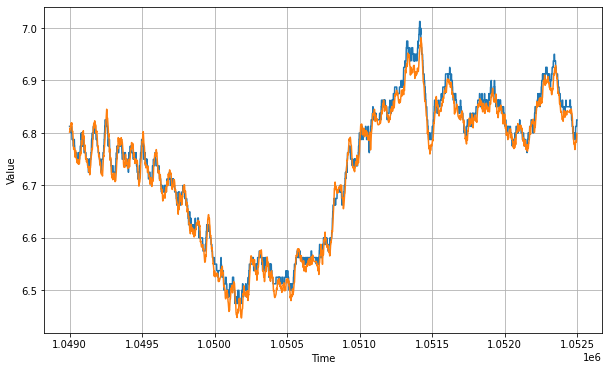

In [ ]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())